# Plotting seasonal box plots

1) Counts of activated pixels (3.75x3.75km) are calculated for each grid (80x80km) at each hour

2) These counts are resampled by each 12z-12z day and summed--then, thresholded by 1

- In other words, did at least one pixel activate within that grid during the period? 1 if so, 0 if no.

3) The grids associated with each sub region are extracted, and the mean daily count is calculated within the region (i.e., maximum of 1 if all grids are active)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up plot

In [2]:
import pandas as pd
import numpy as np
import string
from scipy.stats import mannwhitneyu

letters = string.ascii_lowercase

plt.rcParams['figure.figsize'] = 20,25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

sim_colors = ['#c7e9c0', '#6baed6', '#a50f15']

data_lims = {40:(0, 52), 
             50:(0, 35), 
             60:(0, 15)}

full_name = {'ama':'Amarillo, TX', 
             'mph': 'Memphis, TN', 
             'mnp': 'Minneapolis, MN', 
             'econus': 'ECONUS'}

season_convert = {12: 'DJF', 1: 'DJF', 2: 'DJF', 
                  3: 'MAM', 4: 'MAM', 5: 'MAM', 
                  6: 'JJA', 7: 'JJA', 8: 'JJA', 
                  9: 'SON', 10: 'SON', 11: 'SON'} 

label_props = dict(boxstyle='round', facecolor='w', alpha=1)

# Plot data

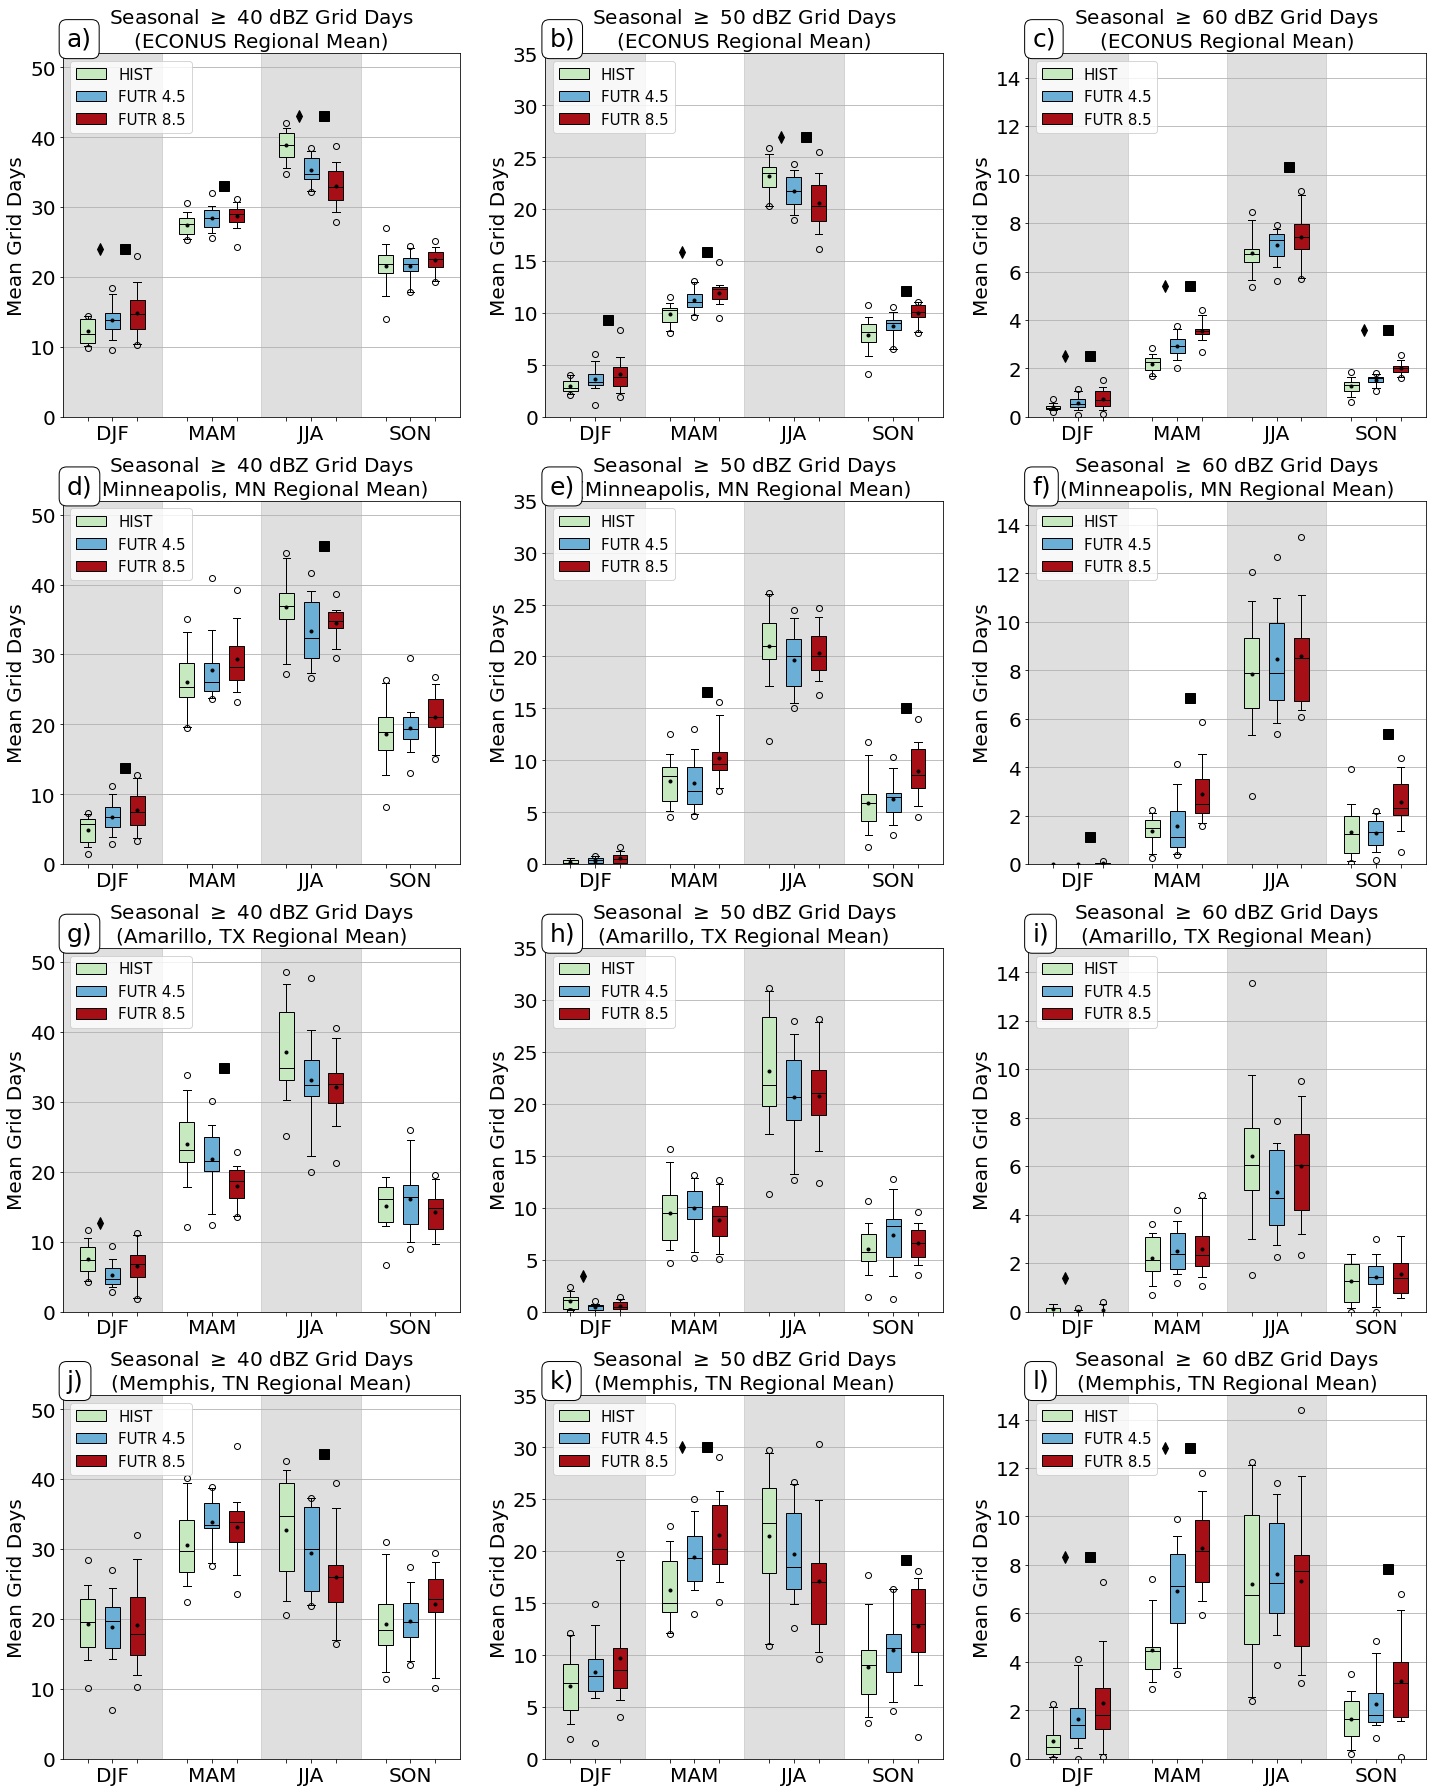

In [3]:
prefix = "../data/boxplot"

for row, region_name in enumerate(['econus', 'mnp', 'ama', 'mph']):
    
    for col, dbz in enumerate(range(40, 70, 10)):
        
        figure_idx = col + (row * 3)
        
        ax = plt.subplot(4, 3, figure_idx + 1)
        ax.set_title(f"Seasonal $\geq$ {dbz} dBZ Grid Days\n({full_name[region_name]} Regional Mean)", size=20)
        
        ax.set_ylabel("Mean Grid Days")
        
        ax.annotate("{})".format(letters[figure_idx]), (0.01,1.02), xycoords='axes fraction',
                    fontsize=25, bbox=label_props, color='k', zorder=25)
        
        ax.grid(axis='y')
        ax.set_ylim(data_lims[dbz][0], data_lims[dbz][1])
        ax.set_xlim(-0.5, 3.5)
        ax.axvspan(-0.5, 0.5, color='grey', alpha=0.25)
        ax.axvspan(1.5, 2.5, color='grey', alpha=0.25)
        
        hist_ = pd.read_csv(f"{prefix}/{region_name}_historical_{dbz}dbz_days.csv", index_col=0, parse_dates=True)
        rcp45_ = pd.read_csv(f"{prefix}/{region_name}_future_4p5_{dbz}dbz_days.csv", index_col=0, parse_dates=True)
        rcp85_ = pd.read_csv(f"{prefix}/{region_name}_future_8p5_{dbz}dbz_days.csv", index_col=0, parse_dates=True)
        
        hist_['season'] = [season_convert[x] for x in hist_.index.month.values]
        rcp45_['season'] = [season_convert[x] for x in rcp45_.index.month.values]
        rcp85_['season'] = [season_convert[x] for x in rcp85_.index.month.values]
        
        bplots = {'HIST':None, 'FUTR 4.5':None, 'FUTR 8.5':None}
        
        seas = {'HIST': {'DJF': [], 'MAM': [], 'JJA': [], 'SON': []},
                'FUTR 4.5': {'DJF': [], 'MAM': [], 'JJA': [], 'SON': []}, 
                'FUTR 8.5': {'DJF': [], 'MAM': [], 'JJA': [], 'SON': []}}
        
        for name, sim in zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], [hist_, rcp45_, rcp85_]):
            for sid, season in sim.groupby('season'):

                season = season.drop(columns=['season'])
                s_ = season.groupby(season.index.year).sum().squeeze()
                seas[name][sid] = s_.values 
        
        for i, s_ in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
            
            bhist = seas['HIST'][s_]
            brcp45 = seas['FUTR 4.5'][s_]
            brcp85 = seas['FUTR 8.5'][s_]
            
            _, ph45 = mannwhitneyu(bhist, brcp45)
            _, ph85 = mannwhitneyu(bhist, brcp85)
            _, p4585 = mannwhitneyu(brcp45, brcp85)
            
            
            bplot = ax.boxplot([bhist, brcp45, brcp85], positions=[i-0.25, i, i+0.25], 
                               patch_artist=True, labels=['', s_, ''], 
                               whis=[5, 95], showmeans=True, meanprops=meanpointprops)
            
            plt.setp(bplot['medians'], color='black')
            [item.set_color('black') for item in bplot['means']] 
            
            for color, patch in zip(sim_colors, bplot['boxes']):
                patch.set_facecolor(color)

            if ph45 < 0.05:
                m45 = ax.plot(i-0.125, np.max([bhist, brcp45, brcp85])+1, "kd", ms=8)

            if ph85 < 0.05:
                m85 = ax.plot(i+0.125, np.max([bhist, brcp45, brcp85])+1, "ks", ms=10)
 
        ax.legend([bplot["boxes"][0], bplot["boxes"][1], bplot["boxes"][2]], 
                  ['HIST', 'FUTR 4.5', 'FUTR 8.5'], loc='upper left', prop={'size':15})

        
plt.tight_layout()

plt.savefig("../figures/fig3.pdf", bbox_inches='tight', dpi=300)